In [1]:
# Basic Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Dataset

data= pd.read_excel("d:Analytics/insurance.xlsx")

data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19.0,female,27.9,0.0,yes,southwest,16884.92
1,18.0,male,33.8,1.0,no,southeast,1725.55
2,28.0,male,33.0,3.0,no,southeast,4449.46
3,33.0,male,22.7,0.0,no,northwest,21984.47
4,32.0,male,28.9,0.0,no,northwest,3866.86


In [3]:
data.shape

(1338, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 73.3+ KB


<AxesSubplot:>

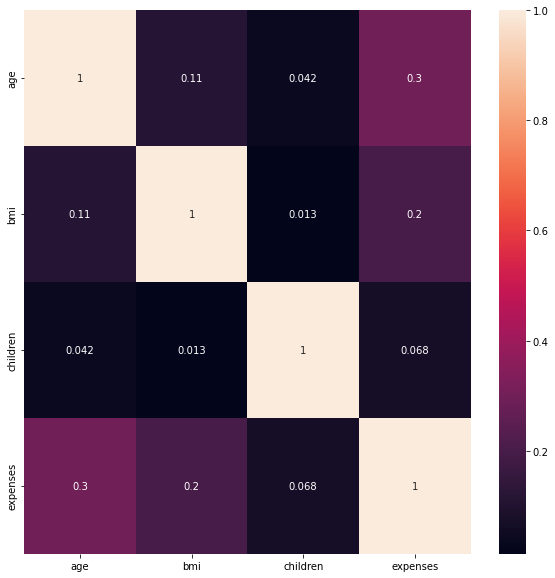

In [5]:
#check the feature correlations

fig, ax = plt.subplots(figsize=(10,10))

corr = data.corr()
sns.heatmap(corr,annot=True, ax=ax)

In [6]:
#save object

import pickle

def save_object(obj, name):
    
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj,pickle_obj)
    pickle_obj.close()

In [7]:
# Label Encode Object Type

d_types = dict(data.dtypes)

for name, type_ in d_types.items():
    if str(type_) == 'object':
        print(f"<============={name}================>")
        print(data[name].value_counts())

<=============sex================>
male      676
female    662
Name: sex, dtype: int64
<=============smoker================>
no     1064
yes     274
Name: smoker, dtype: int64
<=============region================>
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder
for name, type_ in d_types.items():
    if str(type_) == 'object':
        Le= LabelEncoder()
        data[name] = Le.fit_transform(data[name])
        save_object(Le, f"Label_Encoder_ {name}")

In [9]:
# check after label encoding

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   int32  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   int32  
 5   region    1338 non-null   int32  
 6   expenses  1338 non-null   float64
dtypes: float64(4), int32(3)
memory usage: 57.6 KB


In [10]:
# One hot Encoding

from sklearn.preprocessing import OneHotEncoder

onehotcoder = OneHotEncoder()
part = onehotcoder.fit_transform(data['region'].values.reshape(-1,1)).toarray()
save_object(onehotcoder, "OneHotEncoder_region")
values= dict(data["region"].value_counts())

for e,(val , _) in enumerate(values.items()):
    data["region_" + str(val)]=part[:,e]

data = data.drop(["region"], axis=1)
data.head()

,age,sex,bmi,children,smoker,expenses,region_2,region_3,region_1,region_0
0,19.0,0,27.9,0.0,1,16884.92,0.0,0.0,0.0,1.0
1,18.0,1,33.8,1.0,0,1725.55,0.0,0.0,1.0,0.0
2,28.0,1,33.0,3.0,0,4449.46,0.0,0.0,1.0,0.0
3,33.0,1,22.7,0.0,0,21984.47,0.0,1.0,0.0,0.0
4,32.0,1,28.9,0.0,0,3866.86,0.0,1.0,0.0,0.0


Skewness in column : Sqrt Expenses  -0.008734062011873602


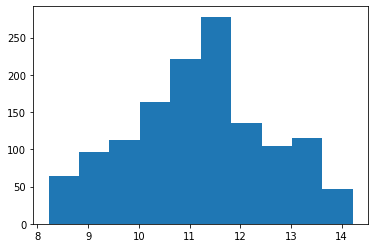

In [11]:
from scipy import stats

col_cox, lam = stats.boxcox(data["expenses"])[0:2]
print("Skewness in column : Sqrt Expenses ", pd.Series(col_cox).skew())

save_object(lam,"boxcox_lambda")

plt.hist(col_cox)
plt.show()

In [12]:
data["expenses"]= col_cox

In [13]:
remaining_columns = list(data.columns)
remaining_columns.remove("expenses")

In [14]:
save_object(remaining_columns,"columns")

In [15]:
x= data[remaining_columns].values
y= data['expenses'].values

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xtrain, Xtest, Ytrain, Ytest= train_test_split(x,y,test_size=0.2, random_state = 4)

Scaler= StandardScaler()
Xtrain = Scaler.fit_transform(Xtrain)
Xtest = Scaler.transform(Xtest)

save_object(Scaler, "Scaler")

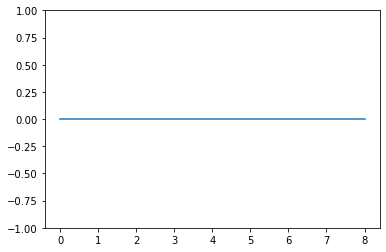

In [17]:
# check if data is standarized or not

plt.ylim(-1,1)

means=[]
for i in range(Xtrain.shape[1]):
    means.append(np.mean(Xtrain[:,i]))
plt.plot(means, scaley=False)    

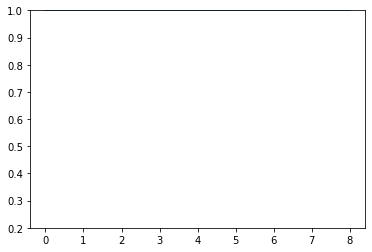

In [18]:
#  check variance

plt.ylim(0.2)

vars=[]
for i in range(Xtrain.shape[1]):
    vars.append(np.var(Xtrain[:,i]))
    
plt.plot(vars)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

pca= PCA(n_components=7)
Xtrain=pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)

pca.explained_variance_ratio_.cumsum()
save_object(pca,"PCA")


In [20]:
# defining Metrics

def rmse_score(y_test, y_pred):
    value =(1/len(y_test))*np.sum((y_test-y_pred)**2)
    return np.sqrt(value)

def r2_score(y_test, y_pred):
    numerator =(1/len(y_test))*np.sum((y_test-y_pred)**2)
    denominator =(1/len(y_test))*np.sum((y_test-np.mean(y_pred))**2)
    return (1-(numerator/denominator))

def mae(y_test,y_pred):
    return(1/len(y_test))* np.sum(np.abs(y_test-y_pred))

def adj_r2_score(y_test, y_pred, n_features):
    numerator = (1-r2_score(y_test)-n_features-1)
    return 1-(numerator/denominator)

In [21]:
model = LinearRegression()
model.fit(Xtrain,Ytrain)

Ypred = model.predict(Xtest)

print("rmse_score: " , rmse_score(Ytest, Ypred))
print("r2_score: " , r2_score(Ytest, Ypred))
print("mae: " , mae(Ytest, Ypred))
print("adj_r2_score " , rmse_score(Ytest, Ypred))


rmse_score:  0.6817554906479536
r2_score:  0.7502778989160275
mae:  0.42150203685060017
adj_r2_score  0.6817554906479536


In [22]:
save_object(model, "MyModel")

# Realtime Prediction

In [23]:
def load_object(name):
    pickle_obj=open(f"{name}.pck","rb")
    obj= pickle.load(pickle_obj)
    return obj

In [24]:
#laod the Data point

data= pd.read_excel("d:/Analytics/insurance.xlsx")

idx = np.random.choice(len(data))
to_be_predicted = data.iloc[idx,:].values

col_names = data.columns
predict_dict = {}

for col_name, val in zip(col_names, to_be_predicted):
    predict_dict[col_name]=val
    
print(predict_dict)
    

{'age': 29.0, 'sex': 'male', 'bmi': 27.9, 'children': 0.0, 'smoker': 'no', 'region': 'southeast', 'expenses': 2867.12}


In [25]:
real_value = predict_dict["expenses"]
del predict_dict["expenses"]

In [26]:
predict_dict["region"] = load_object("Label_Encoder_ region").transform(np.array(predict_dict["region"]).reshape(-1,))

In [27]:
predict_dict["sex"] = load_object("Label_Encoder_ sex").transform(np.array(predict_dict["sex"]).reshape(-1,))[0]

In [28]:
predict_dict["smoker"] = load_object("Label_Encoder_ smoker").transform(np.array(predict_dict["smoker"]).reshape(-1,))[0]

In [29]:
predict_dict

{'age': 29.0,
 'sex': 1,
 'bmi': 27.9,
 'children': 0.0,
 'smoker': 0,
 'region': array([2])}

In [30]:
predict_dict["region_ohe"] = load_object("OneHotEncoder_region").transform(np.array(predict_dict["region"]).reshape(-1,1))[0]

In [31]:
predict_dict

{'age': 29.0,
 'sex': 1,
 'bmi': 27.9,
 'children': 0.0,
 'smoker': 0,
 'region': array([2]),
 'region_ohe': <1x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Row format>}

In [32]:
del predict_dict["region"]

In [33]:
for e in enumerate(predict_dict["region_ohe"]):
    predict_dict["region_" + str(e)]=i

In [34]:
del predict_dict ["region_ohe"]

In [35]:
predict_dict

{'age': 29.0,
 'sex': 1,
 'bmi': 27.9,
 'children': 0.0,
 'smoker': 0,
 "region_(0, <1x4 sparse matrix of type '<class 'numpy.float64'>'\n\twith 1 stored elements in Compressed Sparse Row format>)": 8}

In [36]:
# makes the main array

col_sequence = load_object("columns")
array=[]

for col_name in col_sequence:
    array.append(predict_dict[col_name])

array = np.array(array)

print(array)

KeyError: 'region_2'

In [37]:
array = load_object("Scaler").transform(array.reshape(1,-1))

AttributeError: 'list' object has no attribute 'reshape'

In [38]:
array = load_object("Scaler").transform(array.reshap(1,-1))

AttributeError: 'list' object has no attribute 'reshap'

In [39]:
array = load_object("PCA").transform(array)

ValueError: Expected 2D array, got 1D array instead:
array=[29.   1.  27.9  0.   0. ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
array

In [40]:
prediction = load_object("MyModel").predict(array)
print(prediction)

ValueError: Expected 2D array, got 1D array instead:
array=[29.   1.  27.9  0.   0. ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [41]:
from scipy.special import inv_boxcox

prediction = inv_boxcox(prediction, load_object("boxcox_lambda"))

print(prediction)

NameError: name 'prediction' is not defined

In [42]:
print("original", real_value , ", Predicted", float(prediction[0]))

NameError: name 'prediction' is not defined